## Subjects as 3D vectors
Intra-state differences.

In [1]:
import numpy as np
from pathlib import Path
import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
import hyppo
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

import sys
from collections import defaultdict

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
groups, labels, subjs = get_latents(base_dir, flag="_gcca", ids=True)

<IPython.core.display.Javascript object>

In [3]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

<IPython.core.display.Javascript object>

In [4]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [[a, b] for a, b in y]
state_labels = [b for _, b in y]
trait_labels = [a for a, _ in y]

<IPython.core.display.Javascript object>

In [5]:
subj_scans = defaultdict(lambda: defaultdict(dict))
for state, trait, subj, grads in zip(
    state_labels, trait_labels, np.concatenate(subjs), np.concatenate(groups)
):
    subj_scans[subj][state] = grads[:, 2]
    subj_scans[subj]["trait"] = trait

<IPython.core.display.Javascript object>

In [6]:
subj_diffs = []
subj_traits = []
for key, d in subj_scans.items():
    subj_diffs.append(
        [
            np.linalg.norm(d["compassion"] - d["restingstate"]),
            np.linalg.norm(d["openmonitoring"] - d["restingstate"]),
            np.linalg.norm(d["compassion"] - d["openmonitoring"]),
        ]
    )
    subj_traits.append(d["trait"])
subj_diffs = np.asarray(subj_diffs)

<IPython.core.display.Javascript object>

In [7]:
# %matplotlib inline
# import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


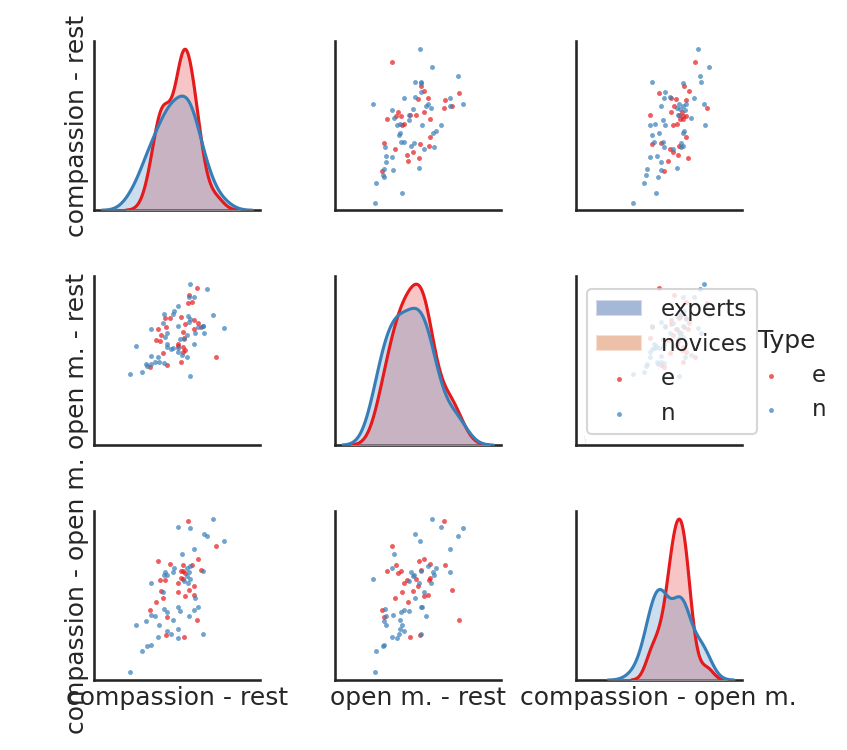

<IPython.core.display.Javascript object>

In [21]:
pairplot(
    np.asarray(subj_diffs),
    subj_traits,
    col_names=["compassion - rest", "open m. - rest", "compassion - open m."],
)

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


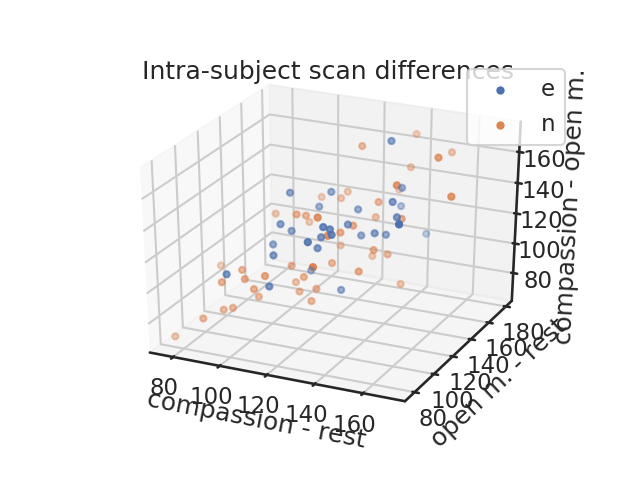

<IPython.core.display.Javascript object>

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for l in np.unique(subj_traits):
    idx = np.where(np.array(subj_traits) == l)[0]
    ax.scatter(
        subj_diffs[idx, 0],
        subj_diffs[idx, 1],
        subj_diffs[idx, 2],
        # c=[int(i == "e") for i in subj_traits],
        cmap="Set1",
        marker="o",
        label=l,
    )

ax.set_xlabel("compassion - rest")
ax.set_ylabel("open m. - rest")
ax.set_zlabel("compassion - open m.")
plt.legend()
plt.title("Intra-subject scan differences")
plt.show()

## MGC on norm of differences

In [22]:
group_idxs = [
    np.where(np.asarray(subj_traits) == trait)[0] for trait in np.unique(subj_traits)
]

<IPython.core.display.Javascript object>

In [1]:
X, Y = k_sample_transform([subj_diffs[idxs] for idxs in group_idxs])

NameError: name 'k_sample_transform' is not defined

In [45]:
# stat, pvalue = hyppo.ksample.KSample("MGC").test(
#     subj_diffs[group_idxs[0]], subj_diffs[group_idxs[1]], reps=1000
# )
stat, pvalue, mgc_dict = multiscale_graphcorr(
    X, Y, workers=-1, reps=1000
)

<IPython.core.display.Javascript object>

In [46]:
print(f"stat {stat}")
print(f"pval {pvalue}")

stat 0.014310419337490936
pval 0.16


<IPython.core.display.Javascript object>

## MVE (Priebe version)

In [23]:
def titterington_algorithm(X, w=None, iterations=100):
    """
    Calculates the weighted Mahalanobis distance for each point and iteratively
    updates the weights until all distances are less than the dimension of the
    observations or the number of iterations is reached.
    """
    n, p = X.shape
    if w is None:
        w = np.ones(n) / n
    else:
        assert w.shape[0] == n

    # Weighted average as
    c = w @ X

    # Covariance matrix
    S = (X - c).T @ np.diag(w) @ (X - c)

    # Compute Mahalanobis distances
    S_inv = np.linalg.inv(S)
    D = np.asarray([(x - c) @ S_inv @ (x - c).T for x in X])
    if np.any(D <= p) and iterations > 0:
        w = w * D / p
        return titterington_algorithm(X, w=w, iterations=iterations - 1)
    else:
        return c, S_inv, np.sqrt(D)


def eid(X, m=None):
    """
    Computes the location and shape of a minimum volume ellipsoid around
    a set of points, invariant to m of those points.
    
    X : (n_samples, n_features)
        Data matrix
    m : int (default=None)
        Number of samples to keep. Set to a default if None
    """
    n, p = X.shape
    X0 = X.copy()
    if m is None:
        m = int(np.ceil((n + p + 1) / 2))
    for _ in range(n - m):
        Xj = X - X.mean(axis=0)
        eid = np.diag(Xj @ np.linalg.inv(Xj.T @ Xj) @ Xj.T)
        # Delete max eid value, excluding any with eid of 1
        max_eid = np.max(list(set(eid) - set([1])))
        X = np.delete(X, np.where(eid == max_eid)[0][0], 0)

    c, S_inv, _ = titterington_algorithm(X)
    D = np.sqrt([(x - c) @ S_inv @ (x - c).T for x in X0])

    return c, S_inv, D

<IPython.core.display.Javascript object>

In [12]:
group_idxs = [
    np.where(np.asarray(subj_traits) == trait)[0] for trait in np.unique(subj_traits)
]

<IPython.core.display.Javascript object>

In [49]:
X_experts, X_novices = [subj_diffs[idxs] for idxs in group_idxs]
X, Y = k_sample_transform([subj_diffs[idxs] for idxs in group_idxs])

<IPython.core.display.Javascript object>

In [24]:
c_e, S_e, D_e = eid(X_experts)
c_n, S_n, D_n = eid(X_novices)

<IPython.core.display.Javascript object>

In [71]:
def test_stat(X, Y, m_frac=None):
    if m_frac is None:
        m1 = None
        m2 = None
    else:
        m1 = int(m_frac * X.shape[0])
        m2 = int(m_frac * Y.shape[0])
    c0, S0, _ = eid(X[np.where(Y == 0)[0]], m=m1)
    c1, S1, _ = eid(X[np.where(Y == 1)[0]], m=m2)
    det_stat = np.linalg.det(S0) - np.linalg.det(S1)
    center_stats = c0 - c1
    return np.concatenate(([det_stat], center_stats))


def permutation_test(
    test_stat, X, labels, n_permutations=100, left_sided=True, **kwargs
):
    """
    Runs a permutation test (one sided) with test statistic from
    provided function f
    """
    y = labels.copy()
    obs_stats = test_stat(X, y, **kwargs)
    pvals = [1 / (n_permutations + 1) for _ in range(len(obs_stats))]

    for _ in range(n_permutations):
        np.random.shuffle(y)
        null_stats = test_stat(X, y, **kwargs)
        for i, (null_stat, obs_stat) in enumerate(zip(null_stats, obs_stats)):
            if left_sided and null_stat <= obs_stat:
                pvals[i] += 1 / (n_permutations + 1)
            elif null_stat >= obs_stat:
                pvals[i] += 1 / (n_permutations + 1)

    return obs_stats, pvals

<IPython.core.display.Javascript object>

In [52]:
_, _, D = eid(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


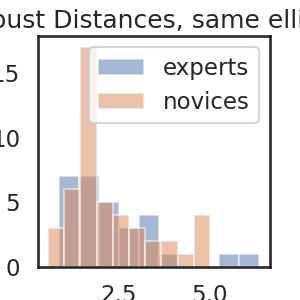

<IPython.core.display.Javascript object>

In [54]:
plt.subplots(1, 1, figsize=(3, 3))
plt.hist(D[np.where(Y == 0)[0]], alpha=0.5, label="experts")
plt.hist(D[np.where(Y == 1)[0]], alpha=0.5, label="novices")
plt.legend()
plt.title("Robust Distances, same ellipse")
plt.show()

In [68]:
obs_stats, pvals = permutation_test(
    test_stat, X, Y, n_permutations=2000, left_sided=False
)

<IPython.core.display.Javascript object>

In [69]:
print(f"pvalues: {pvals}")
print(f"observed test statistics: {obs_stats}")

pvalues: [0.20939530234882414, 0.14792603698150847, 0.1524237881059462, 0.02748625687156425]
observed test statistics: [1.36698833e-07 8.59452902e+00 1.29808773e+01 1.91798731e+01]


<IPython.core.display.Javascript object>

In [72]:
for m_frac in [0.55, 0.65, 0.75, 0.85, 0.95, 1]:
    obs_stats, pvals = permutation_test(
        test_stat, X, Y, n_permutations=2000, left_sided=False, m_frac=m_frac
    )
    print(f"------------ Fraction {m_frac} retained -----------")
    print(f"pvalues: {pvals}")
    print(f"observed test statistics: {obs_stats}")

------------ Fraction 0.55 retained -----------
pvalues: [0.4432783608195862, 0.33183408295851796, 0.6646676661669102, 0.20039980009994868]
observed test statistics: [-5.54550881e-09  8.43797531e+00 -2.87068952e+00  6.05220767e+00]
------------ Fraction 0.65 retained -----------
pvalues: [0.6101949025487199, 0.07246376811594206, 0.12093953023488206, 0.003498250874562718]
observed test statistics: [7.15348837e-10 8.71929175e+00 1.25109532e+01 1.81947657e+01]
------------ Fraction 0.75 retained -----------
pvalues: [0.6356821589205337, 0.07746126936531732, 0.12043978010994454, 0.005997001499250373]
observed test statistics: [7.15348837e-10 8.71929175e+00 1.25109532e+01 1.81947657e+01]
------------ Fraction 0.85 retained -----------
pvalues: [0.6236881559220331, 0.08045977011494247, 0.09295352323838062, 0.002498750624687656]
observed test statistics: [7.15348837e-10 8.71929175e+00 1.25109532e+01 1.81947657e+01]
------------ Fraction 0.95 retained -----------
pvalues: [0.6206896551724079, 

<IPython.core.display.Javascript object>

## Playing around with other statistics

In [11]:
subj_scans = defaultdict(lambda: defaultdict(dict))
for state, trait, subj, grads in zip(
    state_labels, trait_labels, np.concatenate(subjs), np.concatenate(groups)
):
    subj_scans[subj][state] = grads[:, 2]
    subj_scans[subj]["trait"] = trait

subj_vars = []
subj_traits = []
for key, d in subj_scans.items():
    subj_vars.append(
        [
            np.std(d["compassion"] - d["restingstate"]),
            np.std(d["openmonitoring"] - d["restingstate"]),
            np.std(d["compassion"] - d["openmonitoring"]),
        ]
    )
    subj_traits.append(d["trait"])
subj_vars = np.asarray(subj_vars)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


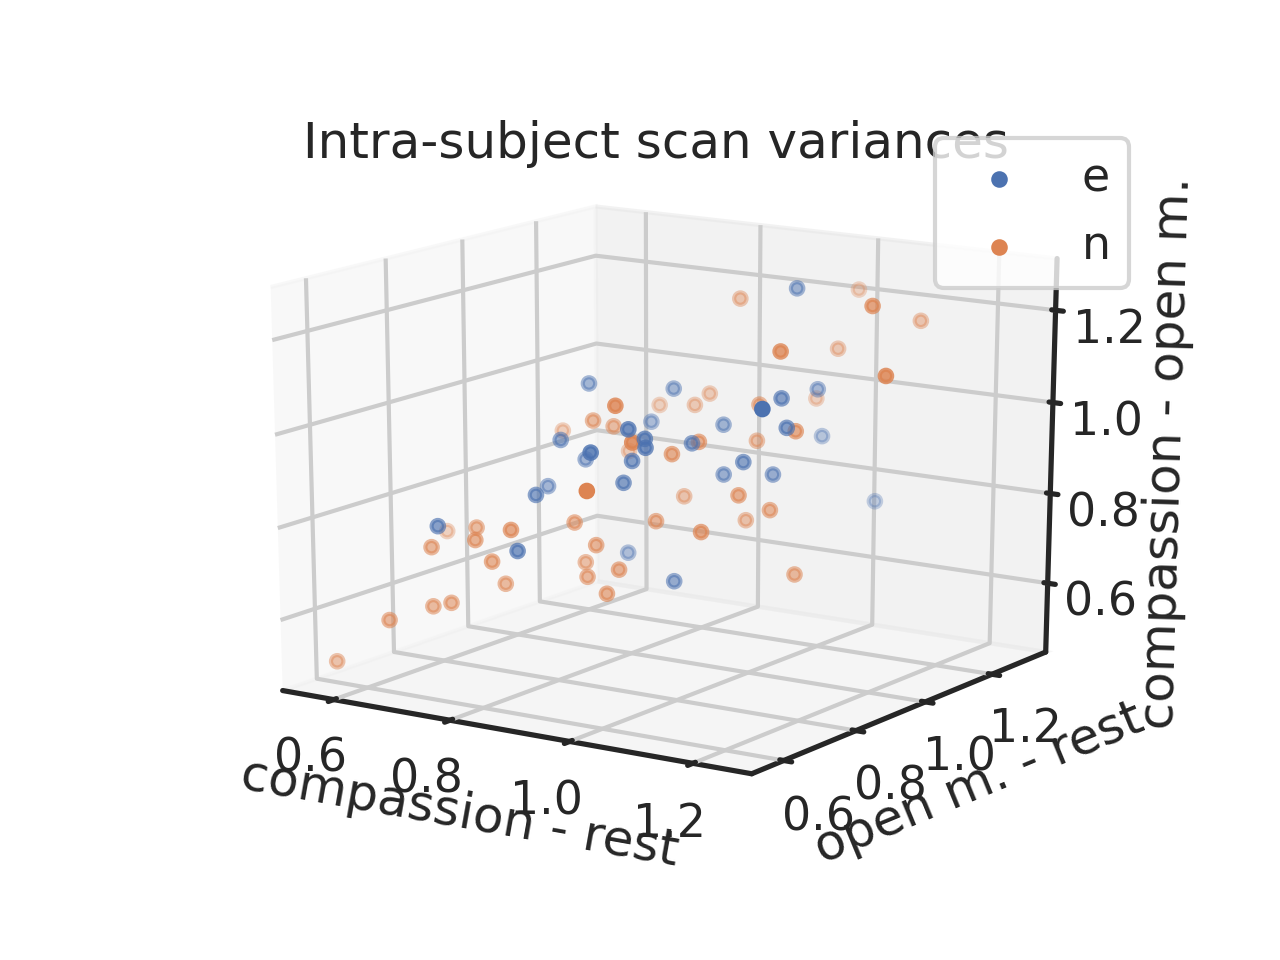

<IPython.core.display.Javascript object>

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for l in np.unique(subj_traits):
    idx = np.where(np.array(subj_traits) == l)[0]
    ax.scatter(
        subj_vars[idx, 0],
        subj_vars[idx, 1],
        subj_vars[idx, 2],
        # c=[int(i == "e") for i in subj_traits],
        cmap="Set1",
        marker="o",
        label=l,
    )

ax.set_xlabel("compassion - rest")
ax.set_ylabel("open m. - rest")
ax.set_zlabel("compassion - open m.")
plt.legend()
plt.title("Intra-subject scan variances")
plt.show()

In [13]:
subj_scans = defaultdict(lambda: defaultdict(dict))
for state, trait, subj, grads in zip(
    state_labels, trait_labels, np.concatenate(subjs), np.concatenate(groups)
):
    subj_scans[subj][state] = grads[:, 2]
    subj_scans[subj]["trait"] = trait

subj_means = []
subj_traits = []
for key, d in subj_scans.items():
    subj_means.append(
        [
            np.mean(d["compassion"] - d["restingstate"]),
            np.mean(d["openmonitoring"] - d["restingstate"]),
            np.mean(d["compassion"] - d["openmonitoring"]),
        ]
    )
    subj_traits.append(d["trait"])
subj_means = np.asarray(subj_means)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


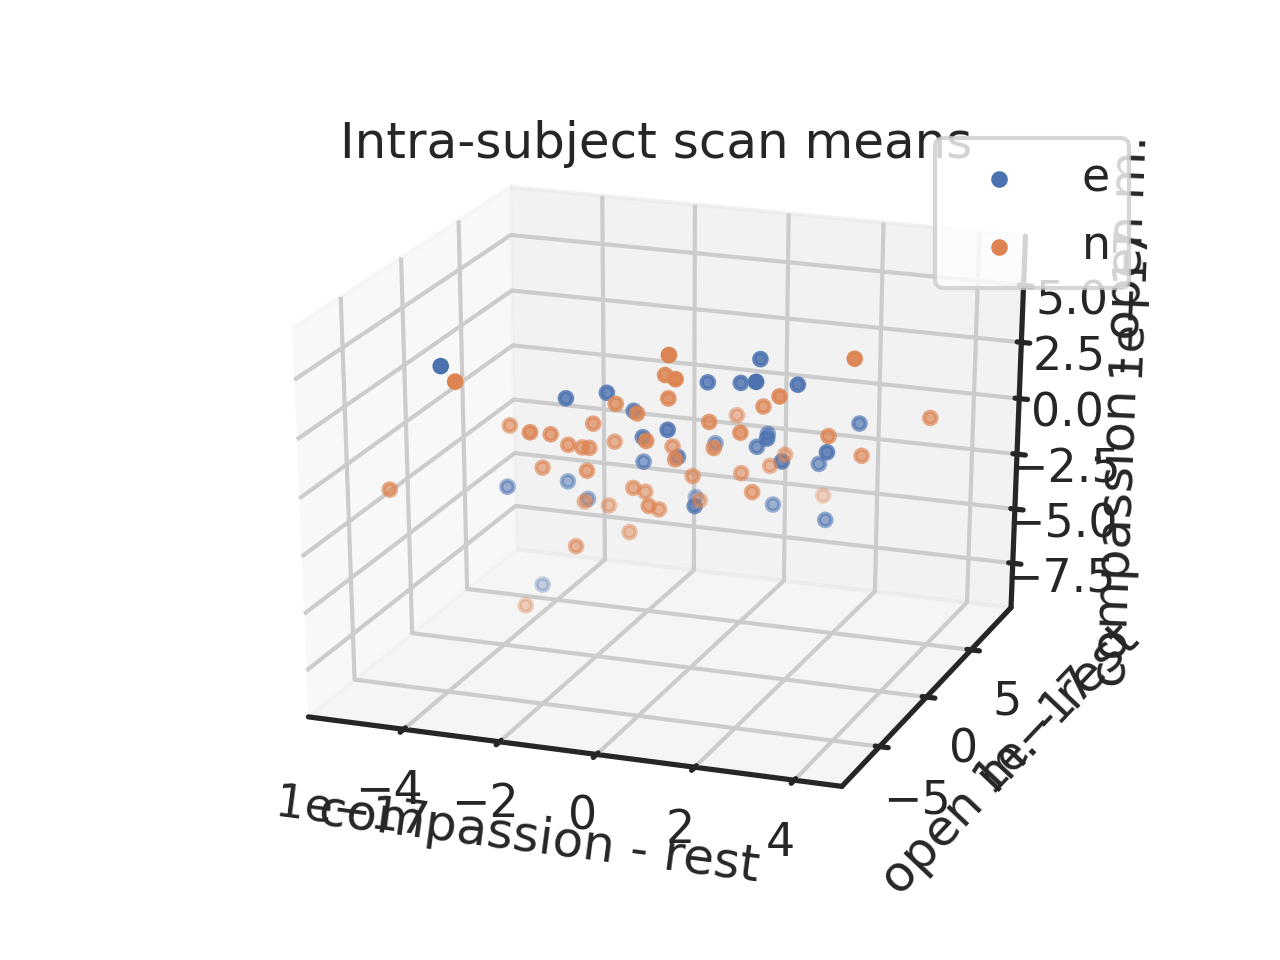

<IPython.core.display.Javascript object>

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for l in np.unique(subj_traits):
    idx = np.where(np.array(subj_traits) == l)[0]
    ax.scatter(
        subj_means[idx, 0],
        subj_means[idx, 1],
        subj_means[idx, 2],
        # c=[int(i == "e") for i in subj_traits],
        cmap="Set1",
        marker="o",
        label=l,
    )

ax.set_xlabel("compassion - rest")
ax.set_ylabel("open m. - rest")
ax.set_zlabel("compassion - open m.")
plt.legend()
plt.title("Intra-subject scan means")
plt.show()